# Module 4 - Reducing unfairness in learning algorithm applications 


### Assignment overview

In this assignment, you are tasked to create a classifer to predict the estimated income of individuals in the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). This dataset is known to be biased towards certain groups. You will try some strategies to create a more fair classifier.

For this assignment, it is possible to work in **groups of up to 2 students**. Read the instructions carefully, as they may assign tasks to specific students.

### Group members
Leave blanks if group has less than 2 members:
- Student 1: Xueyong Zhang
- Student 2: Yuwen Luo


### Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:
1. Discuss the consequences of erroneous (biased) data on the training of learning algorithms and how it impacts its end users  
2. Discuss potential ethical implications in errors in feature selection, model selection 
3. Describe strategies for reducing algorithmic bias 
4. Apply strategies to reduce unfairness in a predictive model trained on an unbalanced dataset 
5. Describe advantages and limitations of the strategies used to reduce unfairness in predictive models

### Libraries

Here are some libraries you will need for this assignment. `imblearn` and `aif360` are new ones, you can install it by running the cell below. Comment out this line after one execution:

In [159]:
# !pip install imblearn
# !pip install aif360

In [160]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from imblearn.over_sampling import SMOTENC
import matplotlib.pyplot as plt
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.datasets import BinaryLabelDataset

import warnings
warnings.filterwarnings('ignore')

### Dataset

The dataset you will use for this assignment is the [Kaggle Adult Income Dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset). You may visit the source page for more information about this dataset.

The dataset includes 15 columns: 14 of them are demographics and other features to describe a person, and one (the target variable), is their income. The income variable is binary and has the two possible values `<=50K` or `>50K`.

Let's start by importing the dataset and taking a look (you are free to add other lines if you want more details):

In [161]:
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


Unfortunately, this dataset is notoriously biased in the association between income and other demographic information, such as race and gender. Let's see how.

#### Question 1 
Create the following 3 bar charts:
- A global bar chart of the target variable
- A bar chart of the target variable divided by gender
- A bar chart of the target variable divided by race

Comment on the results. Is the target variable balanced? Is the target variable balanced across protected groups?

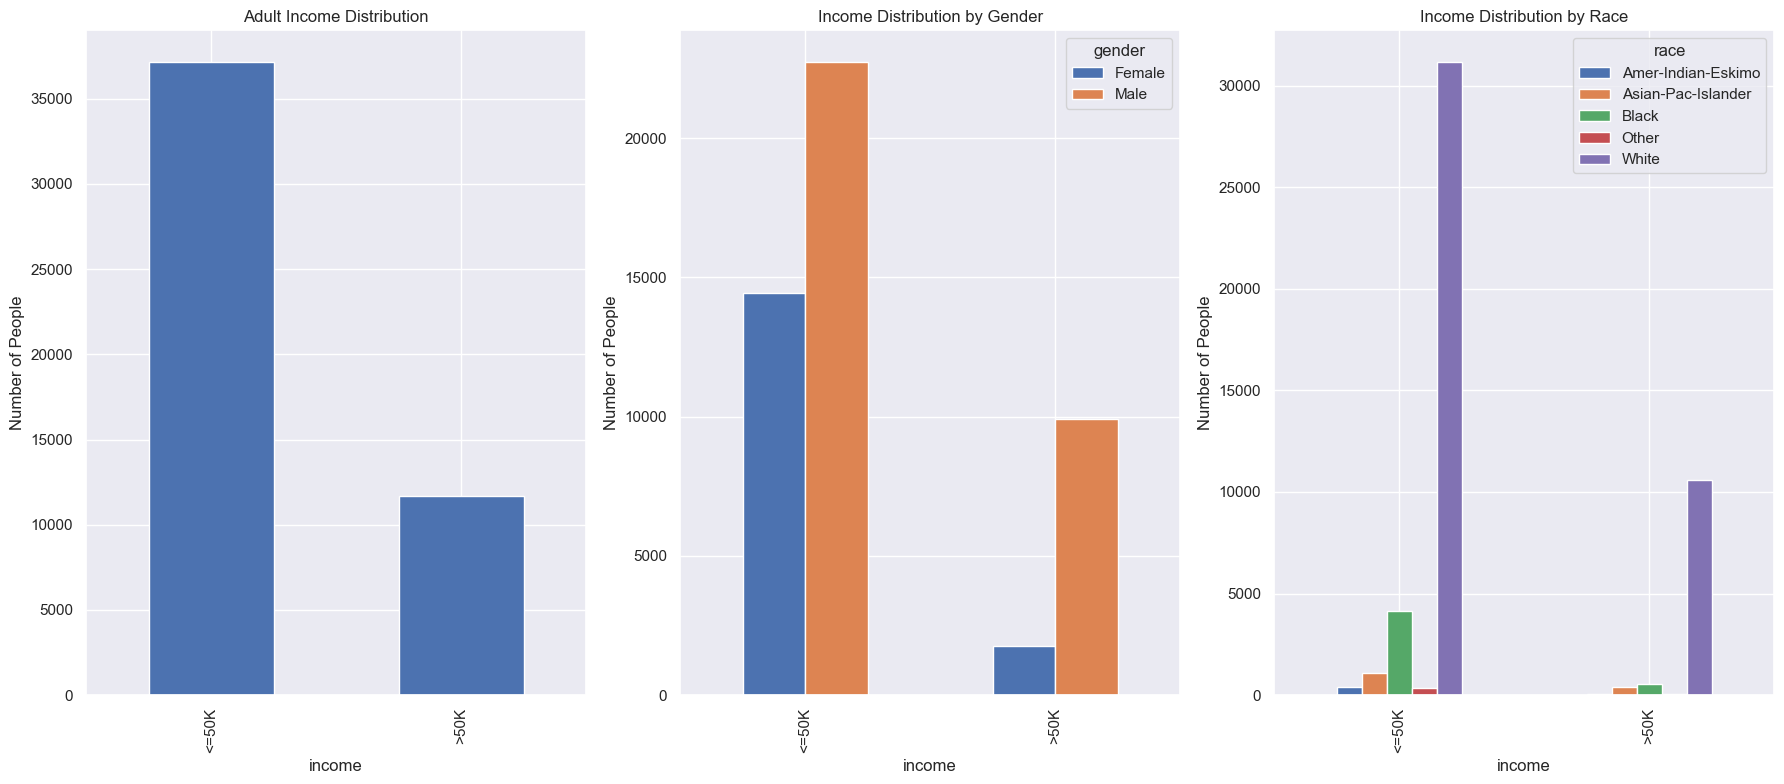

In [162]:
# Your answer here

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# bar chart of the target variable
df['income'].value_counts().plot(kind='bar', ax=axes[0], title='Adult Income Distribution')
axes[0].set_ylabel('Number of People')

# bar chart of the target variable divided by gender
gender_income = df.groupby(['income', 'gender']).size().unstack().plot(kind='bar', ax=axes[1], title='Income Distribution by Gender')
axes[1].set_ylabel('Number of People')

# bar chart of the target variable divided by race
race_income = df.groupby(['income', 'race']).size().unstack().plot(kind='bar', ax=axes[2], title='Income Distribution by Race')
axes[2].set_ylabel('Number of People')


plt.tight_layout()
plt.show()

- The target variable is imbalanced, we have more examples with income that are less or equal to 50k.
- Income distribution is imbalanced across genders, both males and females have a higher count in the <=50K income group. Also, the number of males earning >50K is substantially higher than that of females. This highlights potential gender inequality in income levels within the dataset.
- Income distribution is imbalanced across races. The white people has a much higher representation in the dataset, showing in both <= 50k and >50k groups, compared to other races. Black and Other races fall more in the <=50K category, but are underrepresented in the >50k category. And Asian/Pacific Islander and White individuals have a relatively higher proportion in the >50K category than Black and Other races. The significant disparities could indicate racial biases in income distribution.

### A biased classifier

We can expect that a classifier trained on this kind of data will show some problematic behaviors when assigning an individual to a predicted income level. Let's visualize this using a random forest classifier.

In [163]:
# STEP 1
# Run this cell create training and test sets
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [164]:
# STEP 2
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()

column_names = list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_test_transformed = ct.transform(X_test).toarray()

In [165]:
# You may use this lines to check the result
# pd.DataFrame(X_train_transformed, columns=column_names)
# pd.DataFrame(X_test_transformed, columns=column_names)

In [166]:
# STEP 3
# Run this cell to train a random forest classifer. The hyperparameters have been pre-selected

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_transformed, y_train)

How good is this classifier? Let's check its accuracy, by running the cells below:

In [167]:
clf.score(X_train_transformed, y_train)

0.907046125946942

In [168]:
clf.score(X_test_transformed, y_test)

0.8614618166928274

Finally, let's see what features are considered important by the classifier.

<Axes: >

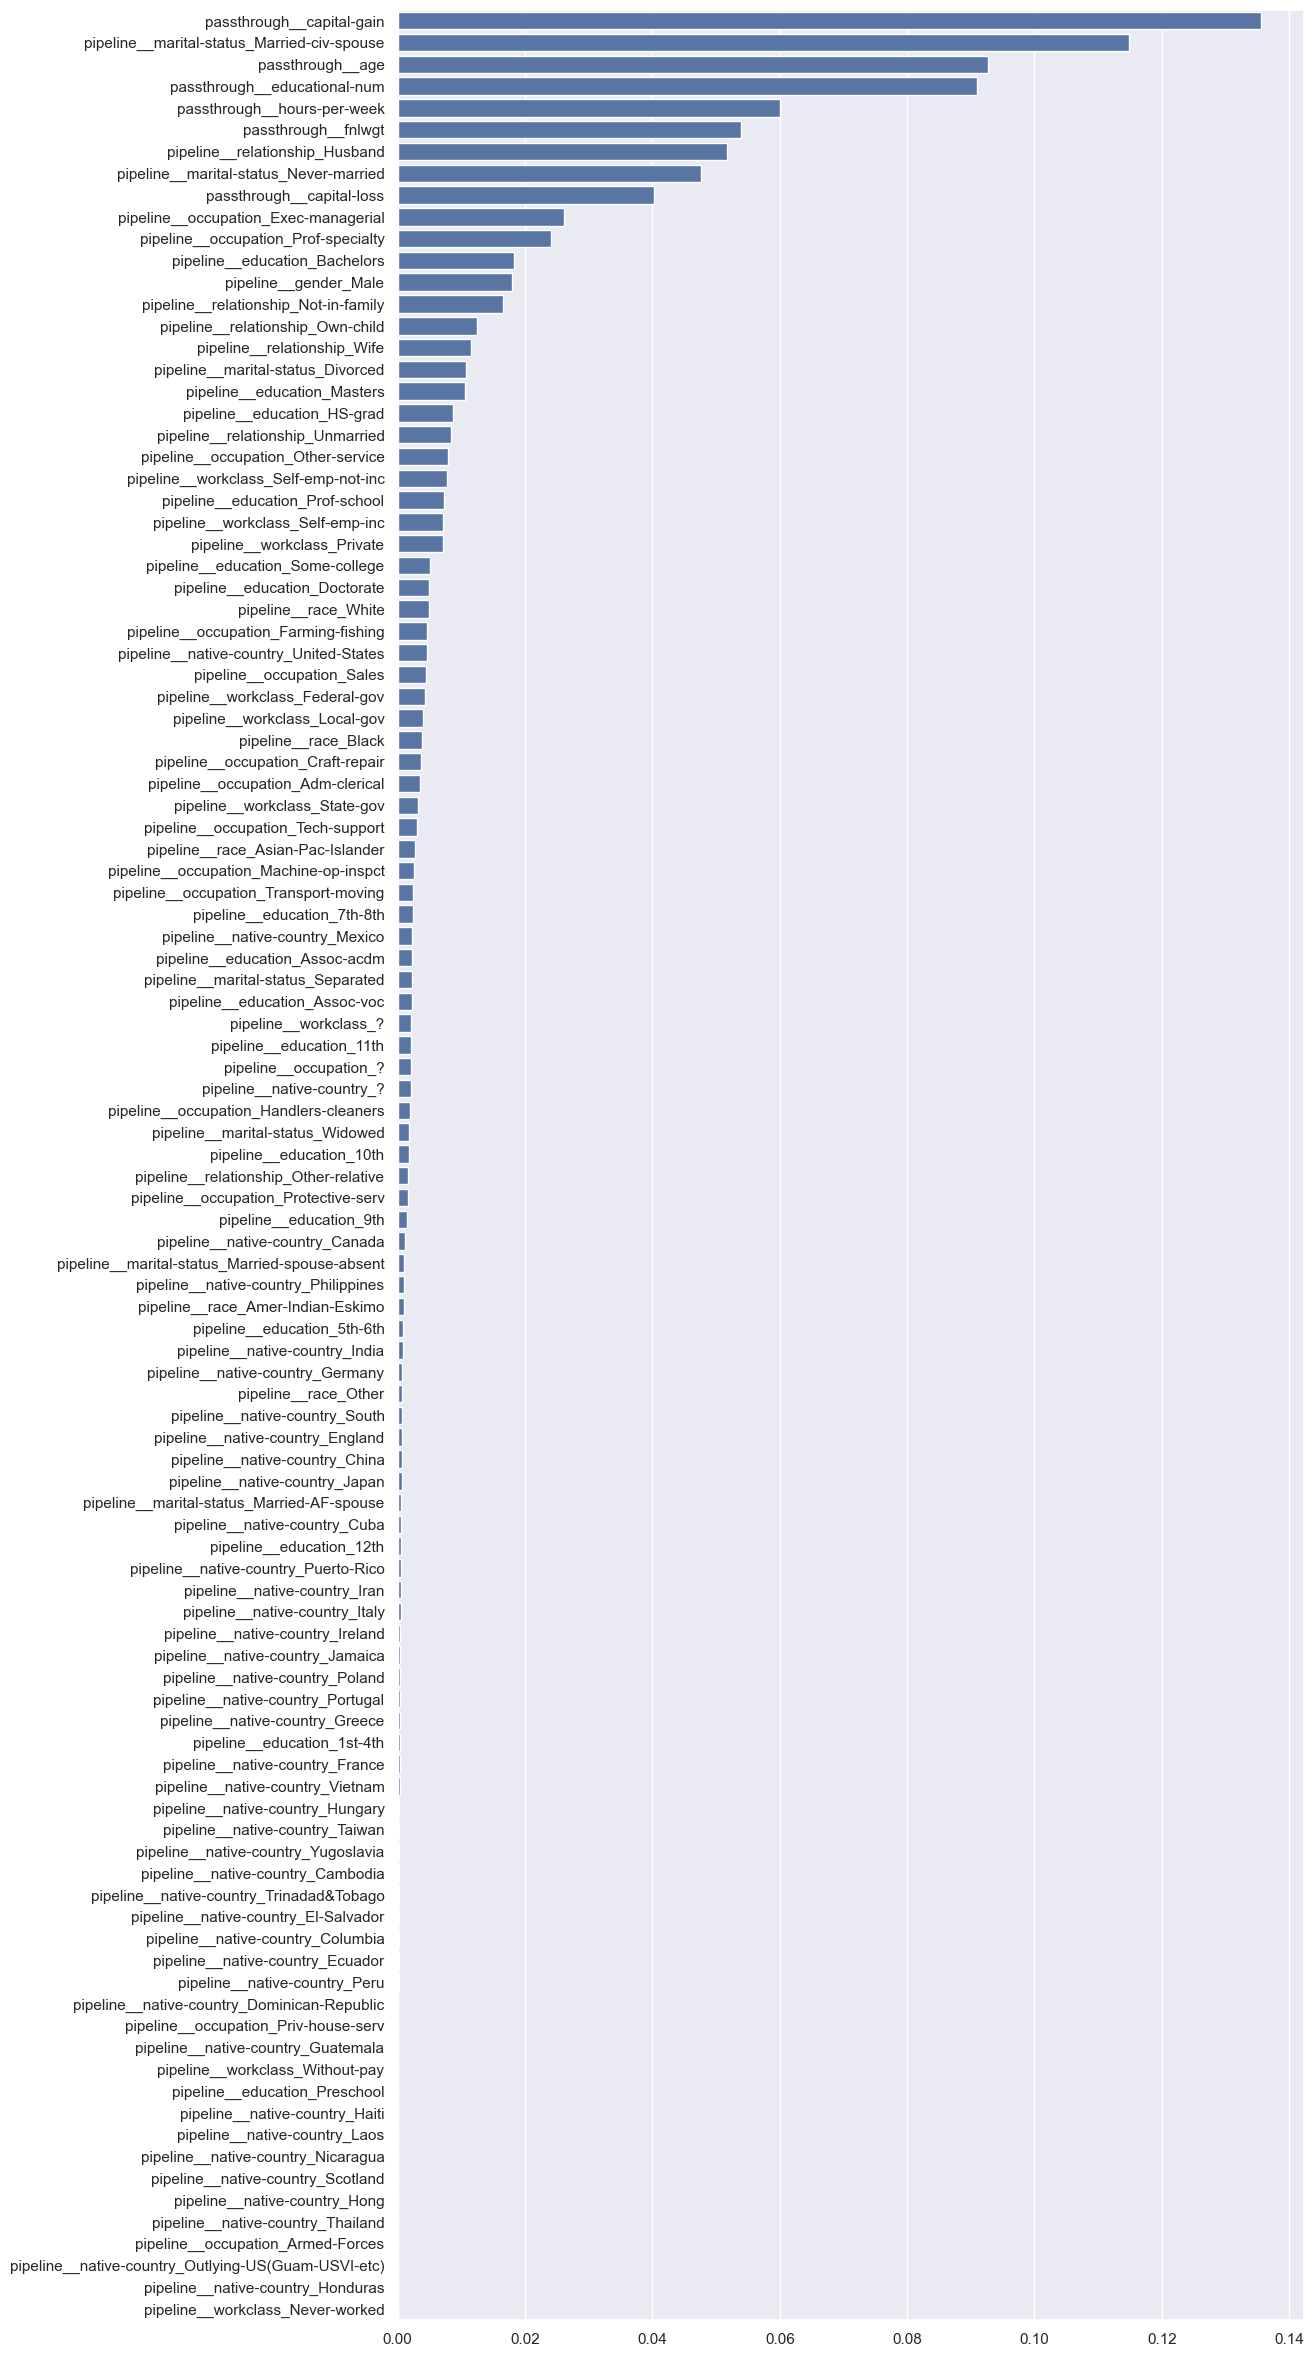

In [169]:
import seaborn as sns

feature_importances = clf.feature_importances_

# Sort the feature importances from greatest to least using the sorted indices
sorted_indices = feature_importances.argsort()[::-1]
sorted_feature_names = ct.get_feature_names_out()[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# # Create a bar plot of the feature importances
sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances, y=sorted_feature_names)

#### Question 2
What are the most important features for this classifier? Do they include protected characteristics, such as race or gender?

These are the five most important features shown in the chart: `capital-gain`, `marital-status`, `age`, `educational-num`, `hours-per-week`.


The protected characteristics: race and gender, are also included. The features related to gender and races, like `gender_Male`, `native_country` and `race_White`, `race_Black`,etc. are considered by the classifier. These protected characteristics should be handled cautiously in predictive modeling to avoid perpetuating bias.


#### Question 3

From Assignment 3, we have learned that a classifier may perform well in terms of accuracy, but being unfair to protected groups in the dataset. Use what you have learned in Assignment 3 and **evaluate this classifier for fairness in treating the two gender groups included in this dataset.** In particular, do the following: 

- Compute the 6 fairness metrics and the Average Distance from the Reference on training and test sets. You may reuse portions of code you have included in Assignment 3.
- Comment on the results, providing an interpretation for each computed metric; how different is the treatment of the two groups? Is one (or more) of the metrics particularly concerning?

Here is a recap of the fairness metrics:
1. *Predicted Positive Rate Disparity (PPRD)*, whether the numbers of positive predictions are on par across groups.
2. *Predicted Positive Group Rate Disparity (PPGRD)*, whether the rates of positive predictions are on par across groups.
3. *False Discovery Rate Disparity (FDRD)*, whether the ratios of false positives to predicted positives are on par across groups.
4. *False Positive Rate Disparity (FPRD)*, whether the ratios of false positives to actual negatives are on par across groups.
5. *False Omission Rate Disparity (FORD)*, whether the ratios of false negatives to predicted negatives are on par across groups.
6. *False Negative Rate Disparity (FNRD)*, whether the ratios of false negatives to actual positives are on par across groups.

In [171]:
# Your answer here (you may add more cells)
from sklearn.metrics import confusion_matrix

# code from assignment 3, 
# female group (group_b) and male group (group_w)
def get_group_confusion_matrix(y_true, y_pred, groups, group_b, group_w):
    cm_b = confusion_matrix(y_true[groups == group_b], y_pred[groups == group_b])
    cm_w = confusion_matrix(y_true[groups == group_w], y_pred[groups == group_w])
    return cm_b, cm_w

def compute_fairness_metrics(cm_b, cm_w):
    tn_b, fp_b, fn_b, tp_b = cm_b.ravel()
    tn_w, fp_w, fn_w, tp_w = cm_w.ravel()
    pprd = (tp_b + fp_b) / (tp_w + fp_w)
    ppgrd = (tp_b + fp_b) / (tp_b + fp_b + tn_b + fn_b) / ((tp_w + fp_w) / (tp_w + fp_w + tn_w + fn_w))
    fdrd = (fp_b / (tp_b + fp_b)) / (fp_w / (tp_w + fp_w))
    fprd = (fp_b / (tn_b + fp_b)) / (fp_w / (tn_w + fp_w))
    ford = (fn_b / (fn_b + tn_b)) / (fn_w / (fn_w + tn_w))
    fnrd = (fn_b / (tp_b + fn_b)) / (fn_w / (tp_w + fn_w))
    average_distance = (abs(pprd - 1) + abs(ppgrd - 1) + abs(fdrd - 1) +
                        abs(fprd - 1) + abs(ford - 1) + abs(fnrd - 1)) / 6
    return {"PPRD": pprd, "PPGRD": ppgrd, "FDRD": fdrd, "FPRD": fprd, "FORD": ford, "FNRD": fnrd, 'Average Distance from Reference': average_distance}


# generate predictions
y_train_pred = clf.predict(X_train_transformed)
y_test_pred = clf.predict(X_test_transformed)

gender_train = X_train['gender']
gender_test = X_test['gender']
fairness_metrics = {}

cm_b_train, cm_w_train = get_group_confusion_matrix(y_train, y_train_pred, train_df['gender'], "Female", "Male")
cm_b_test, cm_w_test = get_group_confusion_matrix(y_test, y_test_pred, test_df['gender'], "Female", "Male")
fairness_metrics["Orignal_Train"] = compute_fairness_metrics(cm_b_train, cm_w_train)
fairness_metrics["Orignal_Test"] = compute_fairness_metrics(cm_b_test, cm_w_test)

# convert to DataFrame 
fairness_metrics_df = pd.DataFrame.from_dict(fairness_metrics, orient='index')

fairness_metrics_df



,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,Average Distance from Reference
Orignal_Train,0.172842,0.349042,0.370874,0.101238,0.265089,0.883967,0.642825
Orignal_Test,0.140122,0.281567,0.817173,0.179615,0.357543,1.237044,0.576837


- Predicted Positive Rate Disparity: PPRD is significantly lower than 1 for both train and test sets, which means the male group has a much higher number of positive predictions, showing that the classifier produces higher income for males than females in both the training and testing sets. This highlights a potential bias towards favorable outcomes for males.

- Predicted Positive Group Rate Disparity: PPGRD is lower than 1 for both train and test sets, which means a higher percentage of males receive positive predictions than females. This highlights the model has a bigger chance to predict males with higher income rather than females.

- False Discovery Rate Disparity: FDRD is lower than 1(test set FDRD is slightly lower than 1), which means the male group has a higher(slightly in test set) proportion of false positive predictions in positives than females. This highlights a potential bias that males are more likely to be predicted with higher income while they are actually not.

- False Positive Rate Disparity: FPRD is significantly lower than 1 both in train and test set, which means the male group has a significantly higher ratio of false positives to actual negatives than females. This suggests a bias that males with low income are more likely to be falsely predicted with higher income.

- False Omission Rate Disparity: FORD is lower than 1 for both train and test sets, which means the male group has a higher ratio of false negatives to predicted negatives than females. This highlights a bias that males are more likely to be predicted with lower income while they actually have high income. 

- False Negative Rate Disparity: FNRD is slightly lower than 1 for train test while slightly higher than 1 for test set, which means there is no larger difference in the ratio of false negatives to actual positives between males and females.

- Average Distance from the Reference: The metric summarizes the disparity between all metrics, with lower values indicating closer alignment with ideal fairness. The value are 0.64 and 0.57 for train and test sets, the train set has a slightly higher score than the test set. This means generally, the classifier exhibits a higher degree of bias towards females than males(favorable outcomes for males), and it is more biased on the train set than the test set.

Both PPRD and FPRD are extremely low, however, PPRD is less in concern because the data itself is very unbalanced, which will result in a low PPRD even if the model don't have any bias. So FNRD is particularly concerning because it highlights an unequal rate of misclassification between groups, leading to potentially unfair consequences for the disadvantaged group. This imbalance may cause certain individuals to be unjustly included in negative outcomes or interventions, compromising both the fairness and trustworthiness of the model’s predictions. Addressing FPRD is critical to ensure equitable treatment across all groups and to reduce unintended adverse impacts. 

## Debiasing techniques: dropping protected characteristics

A first idea to fix this issue could be dropping the protected characteristics from our dataset before training the classifier. Let's try this out and see if there is any improvement.

#### Question 4
1. Drop race, gender and native country from training and test set (we are focusing on gender but we will drop race and native country for good measure).
2. Transform the cleaned dataset using one-hot encoding.
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous one. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Note that, to compare fairness, you will need to have a way to identify the gender of each sample, even though you are not using this feature for classification.
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the first one?

**Hint:** steps 2, 3 and 5 can be completed by tweaking the starting code given at the beginning of this assignment. Ask a TA or instructor if you need help in doing that.

In [52]:
# Your answer here (you may add more cells)

# 1: drop race, gender and native country
X_train_cleaned = X_train.drop(columns=['gender', 'race', 'native-country'])
X_test_cleaned = X_test.drop(columns=['gender', 'race', 'native-country'])

In [53]:
# 2. transform the cleaned dataset
# update the list of categorical features
categorical_feats_cleaned = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                    #  "race",
                    #  "gender",
                    #  "native-country",
                     ]  # Apply one-hot encoding

ct_cleaned = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats_cleaned,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

# Transform the data
X_train_transformed_cleaned = ct_cleaned.fit_transform(X_train_cleaned)
X_test_transformed_cleaned = ct_cleaned.transform(X_test_cleaned)

In [54]:
# 3. Re-train the random forest classifier.

clf_cleaned = RandomForestClassifier(random_state=0, max_depth=19, n_estimators=100)
clf_cleaned.fit(X_train_transformed_cleaned, y_train)

RandomForestClassifier(max_depth=19, random_state=0)

In [55]:
# calculate new accuracies
accuracy_train_cleaned = clf_cleaned.score(X_train_transformed_cleaned, y_train)
accuracy_test_cleaned = clf_cleaned.score(X_test_transformed_cleaned, y_test)

# compare
accuracy_train_original = clf.score(X_train_transformed, y_train)
accuracy_test_original = clf.score(X_test_transformed, y_test)
accuracy_comparison = pd.DataFrame({
    "Model": ["Original", "Cleaned"],
    "Training Set Accuracy": [accuracy_train_original, accuracy_train_cleaned],
    "Testing Set Accuracy": [accuracy_test_original, accuracy_test_cleaned]
})
accuracy_comparison


,Model,Training Set Accuracy,Testing Set Accuracy
0,Original,0.907046,0.861462
1,Cleaned,0.919009,0.861530


The cleaned model just shows a slight improvement in training set accuracy, and the test accuracy remained virtually unchanged. This suggests that removing the protected attributes has not detrimentally impacted the classifier's ability to generalize, but rather has slightly improved its learning from the training data.

In [172]:
# 4. Compare Accuracy and Fairness
# Fairness metrics would need to be recalculated using predictions from the new classifier
y_train_pred_cleaned = clf_cleaned.predict(X_train_transformed_cleaned)
y_test_pred_cleaned = clf_cleaned.predict(X_test_transformed_cleaned)

cm_b_train, cm_w_train = get_group_confusion_matrix(y_train, y_train_pred_cleaned, train_df['gender'], "Female", "Male")
cm_b_test, cm_w_test = get_group_confusion_matrix(y_test, y_test_pred_cleaned, test_df['gender'], "Female", "Male")
fairness_metrics["Cleaned_Train"] = compute_fairness_metrics(cm_b_train, cm_w_train)
fairness_metrics["Cleaned_Test"] = compute_fairness_metrics(cm_b_test, cm_w_test)

# convert to DataFrame 
fairness_metrics_df = pd.DataFrame.from_dict(fairness_metrics, orient='index')

fairness_metrics_df


,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,Average Distance from Reference
Orignal_Train,0.172842,0.349042,0.370874,0.101238,0.265089,0.883967,0.642825
Orignal_Test,0.140122,0.281567,0.817173,0.179615,0.357543,1.237044,0.576837
Cleaned_Train,0.175075,0.353552,0.279112,0.077174,0.255225,0.853163,0.667783
Cleaned_Test,0.150408,0.302237,0.985436,0.232500,0.351786,1.214334,0.531995


The fairness metrics show minimal change in disparities between gender groups in both training and test sets, this suggesting the fundamental biases related to gender remain largely unchanged, the classifier still exhibits a higher degree of bias towards females than males.

Dropping the gender feature does not directly improve fairness metrics because removing it doesn’t fully address underlying patterns and biases present in other correlated features. Even without explicit gender information, the model can infer gender indirectly from other variables, such as occupation, marital status, or work hours, which can carry similar biases related to income distribution. As a result, disparities in fairness metrics may persist, since the model still reflects societal inequities embedded in the data.

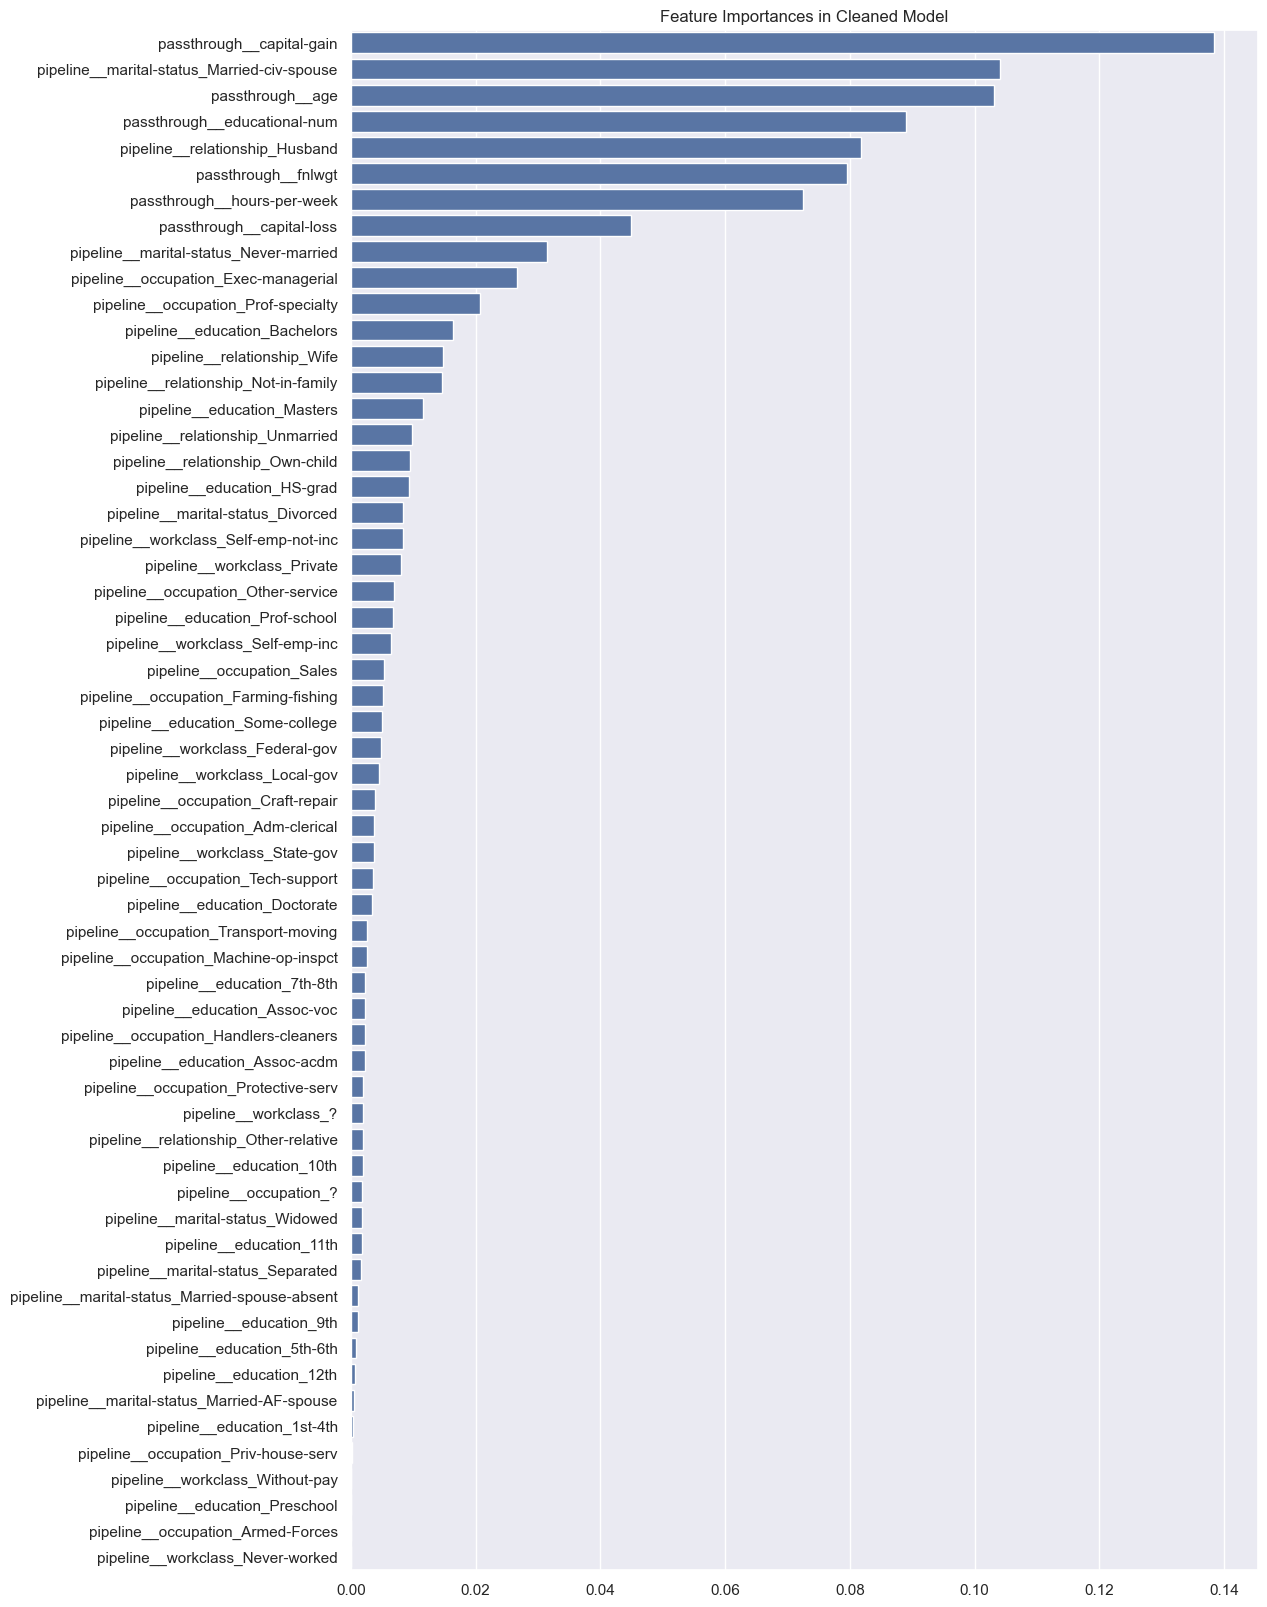

In [57]:
# 5. plot of the feature importance
feature_importances_cleaned = clf_cleaned.feature_importances_
sorted_indices_cleaned = feature_importances_cleaned.argsort()[::-1]
sorted_feature_names_cleaned = ct_cleaned.get_feature_names_out()[sorted_indices_cleaned]
sorted_importances_cleaned = feature_importances_cleaned[sorted_indices_cleaned]

sns.set(rc={'figure.figsize':(11.7,20)})
sns.barplot(x=sorted_importances_cleaned, y=sorted_feature_names_cleaned)
plt.title('Feature Importances in Cleaned Model')
plt.show()

Changes in Feature Importance
- Original Model: Important features included capital gain, age, marital status, education, and work hours. The model also showed significance in protected attributes like gender and race.
- Cleaned Model: also show capital gain, age, marital status, education, and work hours as important features. And more emphasis on other demographic, martial status (husband or wife), which can be a proxy for gender, and occupational features, potentially compensating for the absence of the direct gender and race indicators.
The new feature importance plot show importance on other indicators that might still be proxies for the removed attributes. If these proxies (like certain occupations or marital statuses) carry the same societal biases, they will continue to influence the model in similar ways.


## Debiasing techniques: undersampling

As you should have seen when exploring the dataset, the groups of males and females who make more or less than \\$50k are of very different sizes. This alone may have a significant impact on the way the classifier is trained, by teaching it that some groups are much more likely to make more than \\$50k than others.

Let's try to fix this problem by creating a more balanced training set.

#### Question 5
1. Run the cell below to create a new training set by selecting a subset of samples from the original one, in which the groups of males and females who make more or less than \\$50k are of equal size. To use the maximum number of training samples possible, the size of each group should be equal to the size of the smallest of these groups in the original dataset. **What is the size of each group, and of the final training set?**
2. Separate features from target, and transform the cleaned dataset using one-hot encoding. **Remeber to re-transform the test set accordingly!**
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous ones. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Pay particular attention to the difference in results on the training and test set: can you explain these results?
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the previous ones?


In [58]:
# Check the distribution of gender and income
gender_distribution = train_df['gender'].value_counts()
income_distribution = train_df['income'].value_counts()

# Create balanced subsets
balanced_subsets = []
smallest = train_df.shape[0]

# Finding size of smallest subset by gender and income
for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        if train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)].shape[0] < smallest:
            smallest = train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)].shape[0]
    
# Sampling subsets 
for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        subset = train_df[(train_df['gender'] == gender_category) & (train_df['income'] == income_category)]
        subset = subset.sample(smallest)  # Sample to match the minimum count
        balanced_subsets.append(subset)
        
# Merge the balanced subsets to create the final balanced dataset
balanced_df = pd.concat(balanced_subsets)

In [59]:
group_sizes = {}

for gender_category in gender_distribution.index:
    for income_category in income_distribution.index:
        group_key = f"{gender_category} with income: {income_category}"
        group_sizes[group_key] = smallest

group_sizes['Final Training Set(total)'] = balanced_df.shape[0]
group_sizes_df = pd.DataFrame.from_dict(group_sizes, orient='index', columns=['Group Size']).reset_index()
group_sizes_df.columns = ['Group', 'Size']
group_sizes_df

,Group,Size
0,Male with income: <=50K,1249
1,Male with income: >50K,1249
2,Female with income: <=50K,1249
3,Female with income: >50K,1249
4,Final Training Set(total),4996


In [60]:
X_balanced = balanced_df.drop(columns=["income"])
y_balanced = balanced_df["income"]


X_balanced_transformed = ct.transform(X_balanced).toarray()
X_test_transformed_balanced = ct.transform(X_test).toarray()

clf_balanced = RandomForestClassifier(random_state=0, max_depth=19, n_estimators=100)
clf_balanced.fit(X_balanced_transformed, y_balanced)

accuracy_train_balanced = clf_balanced.score(X_balanced_transformed, y_balanced)
accuracy_test_balanced = clf_balanced.score(X_test_transformed_balanced, y_test)

next_index = accuracy_comparison.index.max() + 1
accuracy_comparison.loc[next_index] = ["Balanced", accuracy_train_balanced, accuracy_test_balanced]
accuracy_comparison.index = accuracy_comparison.index + 1
accuracy_comparison = accuracy_comparison.sort_index()

accuracy_comparison

,Model,Training Set Accuracy,Testing Set Accuracy
1,Original,0.907046,0.861462
2,Cleaned,0.919009,0.861530
3,Balanced,0.962170,0.802361


For the accuracy, we can see that the training set accuracy has a big boost compared to original model, however, the testing set accuracy has a big drop compared to original model. This means undersampling the training set make the model overfit on the training set, decreased the ability of the model to correctly predict the income. 

Undersampling reduces the training set size by removing samples from the majority class, which limits the model's exposure to a full range of income-related patterns and increases its risk of overfitting to specific training data. This focus on a smaller, less diverse sample makes the model less effective at predicting income accurately across a broader population, as it’s overly tuned to the specifics of the undersampled data.

In [173]:
y_train_pred_balanced = clf_balanced.predict(X_balanced_transformed)
y_test_pred_balanced = clf_balanced.predict(X_test_transformed_balanced)

cm_b_train, cm_w_train = get_group_confusion_matrix(y_balanced, y_train_pred_balanced, balanced_df['gender'], "Female", "Male")
cm_b_test, cm_w_test = get_group_confusion_matrix(y_test, y_test_pred_balanced, test_df['gender'], "Female", "Male")
fairness_metrics["Balanced_Train"] = compute_fairness_metrics(cm_b_train, cm_w_train)
fairness_metrics["Balanced_Test"] = compute_fairness_metrics(cm_b_test, cm_w_test)

# convert to DataFrame 
fairness_metrics_df = pd.DataFrame.from_dict(fairness_metrics, orient='index')

fairness_metrics_df

,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,Average Distance from Reference
Orignal_Train,0.172842,0.349042,0.370874,0.101238,0.265089,0.883967,0.642825
Orignal_Test,0.140122,0.281567,0.817173,0.179615,0.357543,1.237044,0.576837
Cleaned_Train,0.175075,0.353552,0.279112,0.077174,0.255225,0.853163,0.667783
Cleaned_Test,0.150408,0.302237,0.985436,0.232500,0.351786,1.214334,0.531995
Balanced_Train,0.959726,0.959726,0.337106,0.323529,0.519560,0.542857,0.392916
Balanced_Test,0.237109,0.476457,1.343874,0.499837,0.227620,0.904338,0.499752


With undersampling, there are notable improvements in the training fairness metrics, such as the PPRD and PPGRD, which now approach parity, and the ADR dropped clearly for both train and test sets, indicating a more equitable model performance between groups in the training set. However, on the test set, improvements are mixed; while some disparities are reduced, others, like FDRD and FPRD, remain high difference to 1. This may reflect the model’s adaptation to a more balanced training distribution, which helps reduce group imbalances in predictions but may introduce some instability on unseen data. Balancing the training set provides a better baseline but does not fully resolve fairness disparities in the test set, underscoring the challenge of generalizing fairness metrics across datasets.

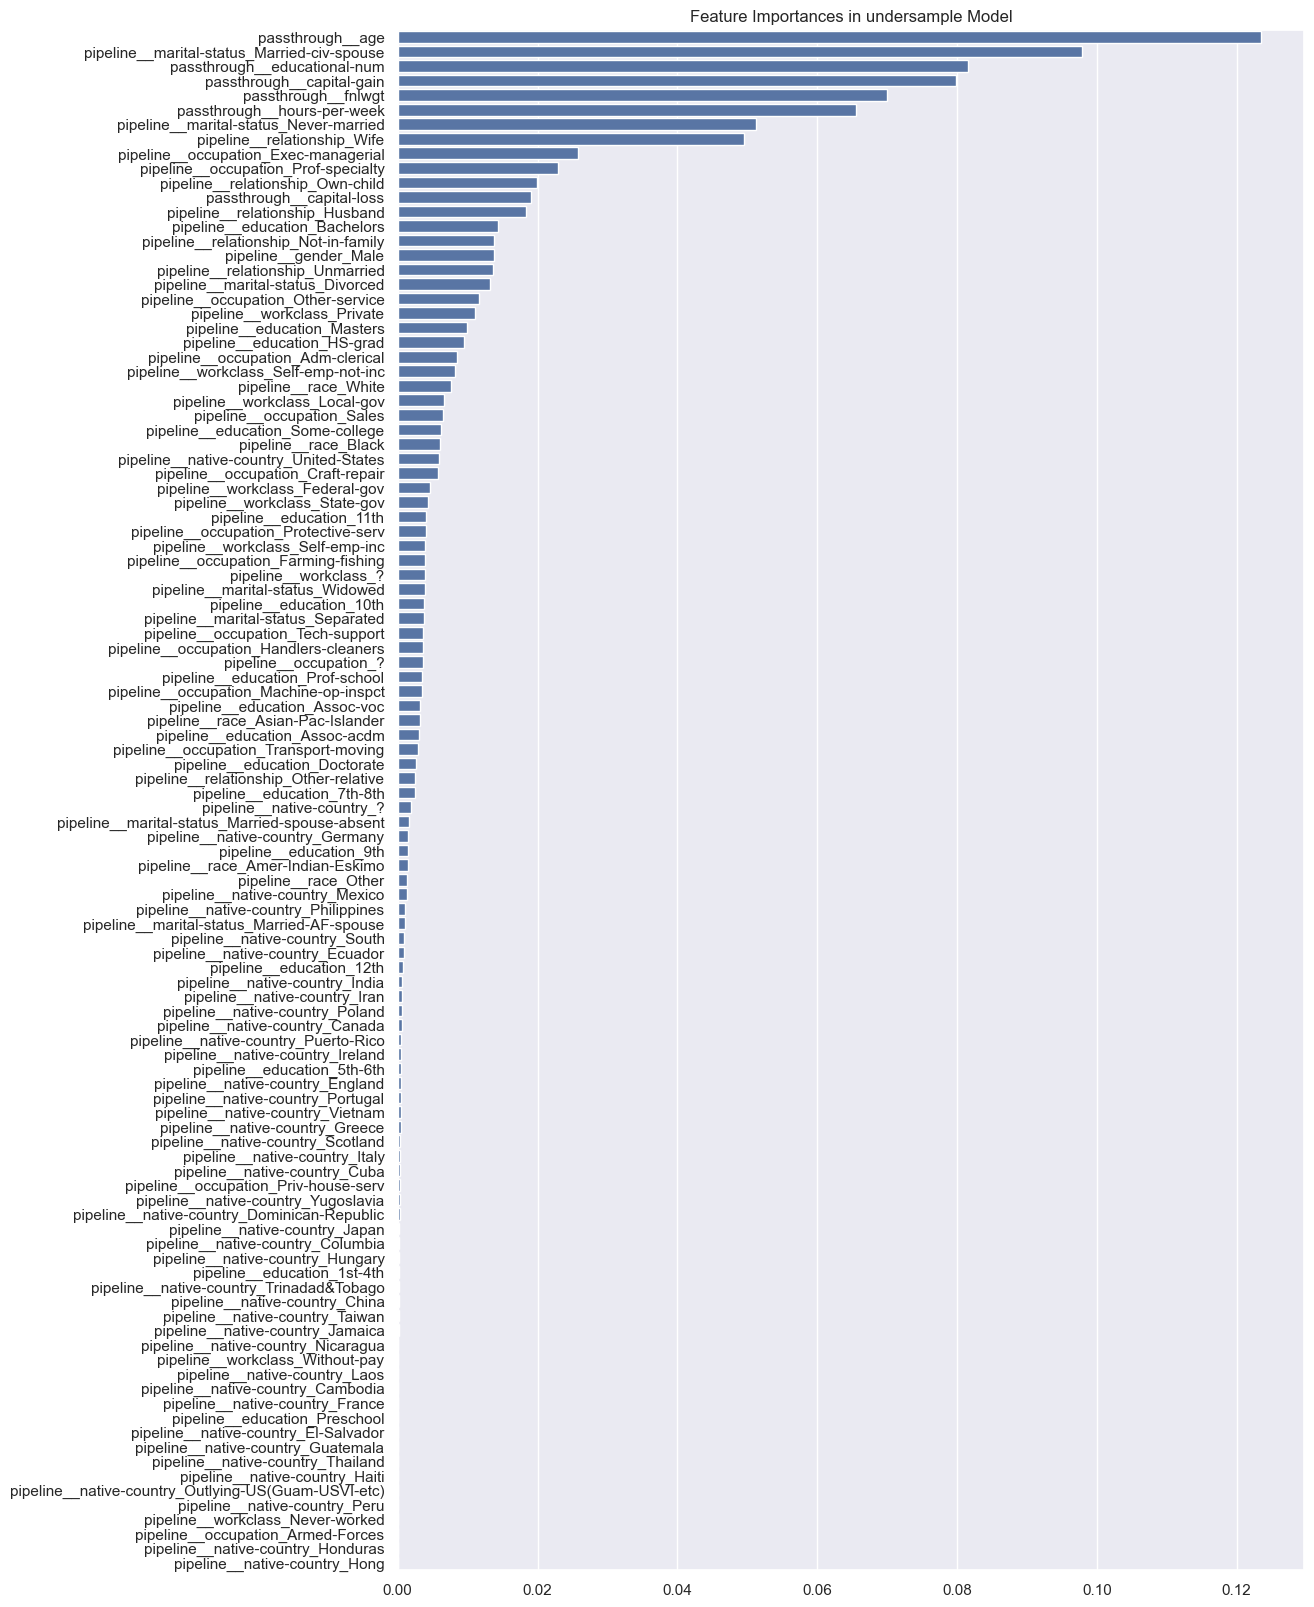

In [65]:
feature_importances_balanced = clf_balanced.feature_importances_
sorted_indices_balanced = feature_importances_balanced.argsort()[::-1]
sorted_feature_names_balanced = ct.get_feature_names_out()[sorted_indices_balanced]
sorted_importances_balanced = feature_importances_balanced[sorted_indices_balanced]

sns.set(rc={'figure.figsize':(11.7,20)})
sns.barplot(x=sorted_importances_balanced, y=sorted_feature_names_balanced)
plt.title('Feature Importances in undersample Model')
plt.show()

Changes in Feature Importance:

The feature `age`, `capital-gain`, `educational-num`, and `hours-per-week` still appear in the top important features in the plots. Their relative rankings are slightly different, but their presence among the top features remains consistent.

The feature `marital-status_Never-married`, `occupation_Prof-specialty` appear lower in the plot, which means those features have less importance int he model. The change may due to the dominance of the majority class is balanced in the training set so the model will not overlook the majority group and ignore the minority group.

## Debiasing techniques: oversampling (with SMOTE)

Another way to create a more balanced training set, but without sacrificing training samples, is by *oversampling*, which means artificially increasing the size of the training set with "fake" samples. This can be achieved mainly in two ways:
1. By resampling (replicating) samples from the original training set, or
2. By introducing artificial *new* samples, similar enough to those included in the original training set

The Synthetic Minority Oversampling Technique (SMOTE) seen in class falls in the second group. In this portion of the assignment, you will create a more balanced dataset using SMOTE (specifically [SMOTENC](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTENC.html), a version of SMOTE that allows working with categorical variables).

#### Question 6
1. Run the cell below to create a more balanced training set using SMOTE. Note that a large portion of code is replicated to guarantee that the correct data is used, and not one modified in previous cells. The actual rebalancing all happens in the last 2 lines.
2. Explore the new training set, and provide the following information: what is the size of the new training set? Is the target variable balanced? How many samples are classified as >\\$50, and how many as <=\\$50k? Is the target variable balanced across protected groups, or at least more balanced than before? How many males and females are classified as >\\$50, and how many as <=\\$50k?
3. Re-train the random forest classifier.
4. Compare accuracy and fairness of this new classifier to the previous ones. Do we see any improvement? How do you explain the changes you see (or lack thereof)? Pay particular attention to the difference in results on the training and test set: can you explain these results?
5. Create a new plot of the feature importance according to this classifier. Do you see any changes from the previous ones?

In [175]:
from imblearn.over_sampling import SMOTENC

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

oversample = SMOTENC(categorical_features=categorical_feats, random_state=0)

X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)


In [177]:
# Transformation applied after oversampling

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"


ctSMOTE = make_column_transformer(
    (
        OneHotEncoder(handle_unknown="ignore",drop="if_binary",sparse_output=False),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ctSMOTE.fit_transform(X_train_SMOTE)
X_test_transformed = ctSMOTE.transform(X_test)

# Column names, if needed
column_names = list(
    ctSMOTE.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

# X_train_transformed and X_test_transformed can now be used to answer the questions above

In [140]:
from collections import Counter
new_training_set_size = X_train_SMOTE.shape[0]
target_balance = Counter(y_train_SMOTE)
income_counts = pd.Series(y_train_SMOTE).value_counts()
gender_income_counts = pd.crosstab(y_train_SMOTE, X_train_SMOTE["gender"], rownames=['Income'], colnames=['Gender'])
group_sizes = {
    "Income >50K": income_counts[">50K"],
    "Income <=50K": income_counts["<=50K"],
    "Males with Income >50K": gender_income_counts.loc[">50K", "Male"],
    "Males with Income <=50K": gender_income_counts.loc["<=50K", "Male"],
    "Females with Income >50K": gender_income_counts.loc[">50K", "Female"],
    "Females with Income <=50K": gender_income_counts.loc["<=50K", "Female"],
    "Final Training Set (total)": new_training_set_size
}
group_sizes_df = pd.DataFrame(list(group_sizes.items()), columns=['Group', 'Size'])

group_sizes_df

,Group,Size
0,Income >50K,25984
1,Income <=50K,25984
2,Males with Income >50K,24015
3,Males with Income <=50K,15910
4,Females with Income >50K,1969
5,Females with Income <=50K,10074
6,Final Training Set (total),51968


We can see target variable is balanced because the size of sample with income>50k and <50k are equal. However, the target variable is not balanced across protected groups because there are significantly more Males with Income >50K than female.

In [73]:
clf_SMOTE = RandomForestClassifier(random_state=0, max_depth=19, n_estimators=100).fit(X_train_transformed, y_train_SMOTE)
accuracy_train_SMOTE = clf_SMOTE.score(X_train_transformed, y_train_SMOTE)
accuracy_test_SMOTE = clf_SMOTE.score(X_test_transformed, y_test)

next_index = accuracy_comparison.index.max() + 1
accuracy_comparison.loc[next_index] = ["SMOTE", accuracy_train_SMOTE, accuracy_test_SMOTE]
accuracy_comparison.index = accuracy_comparison.index + 1
accuracy_comparison = accuracy_comparison.sort_index()

accuracy_comparison

,Model,Training Set Accuracy,Testing Set Accuracy
2,Original,0.907046,0.861462
3,Cleaned,0.919009,0.861530
4,Balanced,0.962170,0.802361
5,SMOTE,0.920682,0.841944


The model trained on SMOTE training set have a lower training set accuracy compared to the model trained on undersampling dataset, but a higher testing set accuracy. This suggests The SMOTE model provided a good trade-off between the training and testing accuracy compared to the previous models, oversampling using SMOTE reduces overfitting compared to the undersampling approach, thus improving performance on unseen data.

In [178]:
y_train_SMOTE_pred = clf_SMOTE.predict(X_train_transformed)
y_test_SMOTE_pred = clf_SMOTE.predict(X_test_transformed)

cm_b_train, cm_w_train = get_group_confusion_matrix(y_train_SMOTE, y_train_SMOTE_pred, X_train_SMOTE['gender'], "Female", "Male")
cm_b_test, cm_w_test = get_group_confusion_matrix(y_test, y_test_SMOTE_pred, test_df['gender'], "Female", "Male")
fairness_metrics["SMOTE_Train"] = compute_fairness_metrics(cm_b_train, cm_w_train)
fairness_metrics["SMOTE_Test"] = compute_fairness_metrics(cm_b_test, cm_w_test)

# convert to DataFrame 
fairness_metrics_df = pd.DataFrame.from_dict(fairness_metrics, orient='index')

fairness_metrics_df

,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,Average Distance from Reference
Orignal_Train,0.172842,0.349042,0.370874,0.101238,0.265089,0.883967,0.642825
Orignal_Test,0.140122,0.281567,0.817173,0.179615,0.357543,1.237044,0.576837
Cleaned_Train,0.175075,0.353552,0.279112,0.077174,0.255225,0.853163,0.667783
Cleaned_Test,0.150408,0.302237,0.985436,0.232500,0.351786,1.214334,0.531995
Balanced_Train,0.959726,0.959726,0.337106,0.323529,0.519560,0.542857,0.392916
Balanced_Test,0.237109,0.476457,1.343874,0.499837,0.227620,0.904338,0.499752
SMOTE_Train,0.072110,0.239060,0.770999,0.087805,0.364001,3.173955,0.939997
SMOTE_Test,0.103781,0.208543,0.655867,0.106772,0.499459,2.105907,0.755248


The SMOTE approach appears to worsen fairness metrics across both training and testing sets, showing higher disparities across most metrics compared to the original version, ADR is increased for both train and test sets. Metrics like FNRD are notably higher than 1 while it's very close to 1 for the original model, suggesting that the model disproportionately misses true positives for certain groups. This happens because SMOTE balanced the target variable (the income groups), but not the gender groups; and SMOTE synthesizes new data points based on existing minority samples, which may amplify noise or minority class imbalances, leading to overfitting on synthetic data rather than improving generalization. Consequently, while SMOTE provides more data points for training, it doesn’t directly resolve the fairness issues and may inadvertently increase disparities by failing to represent group-based patterns accurately.

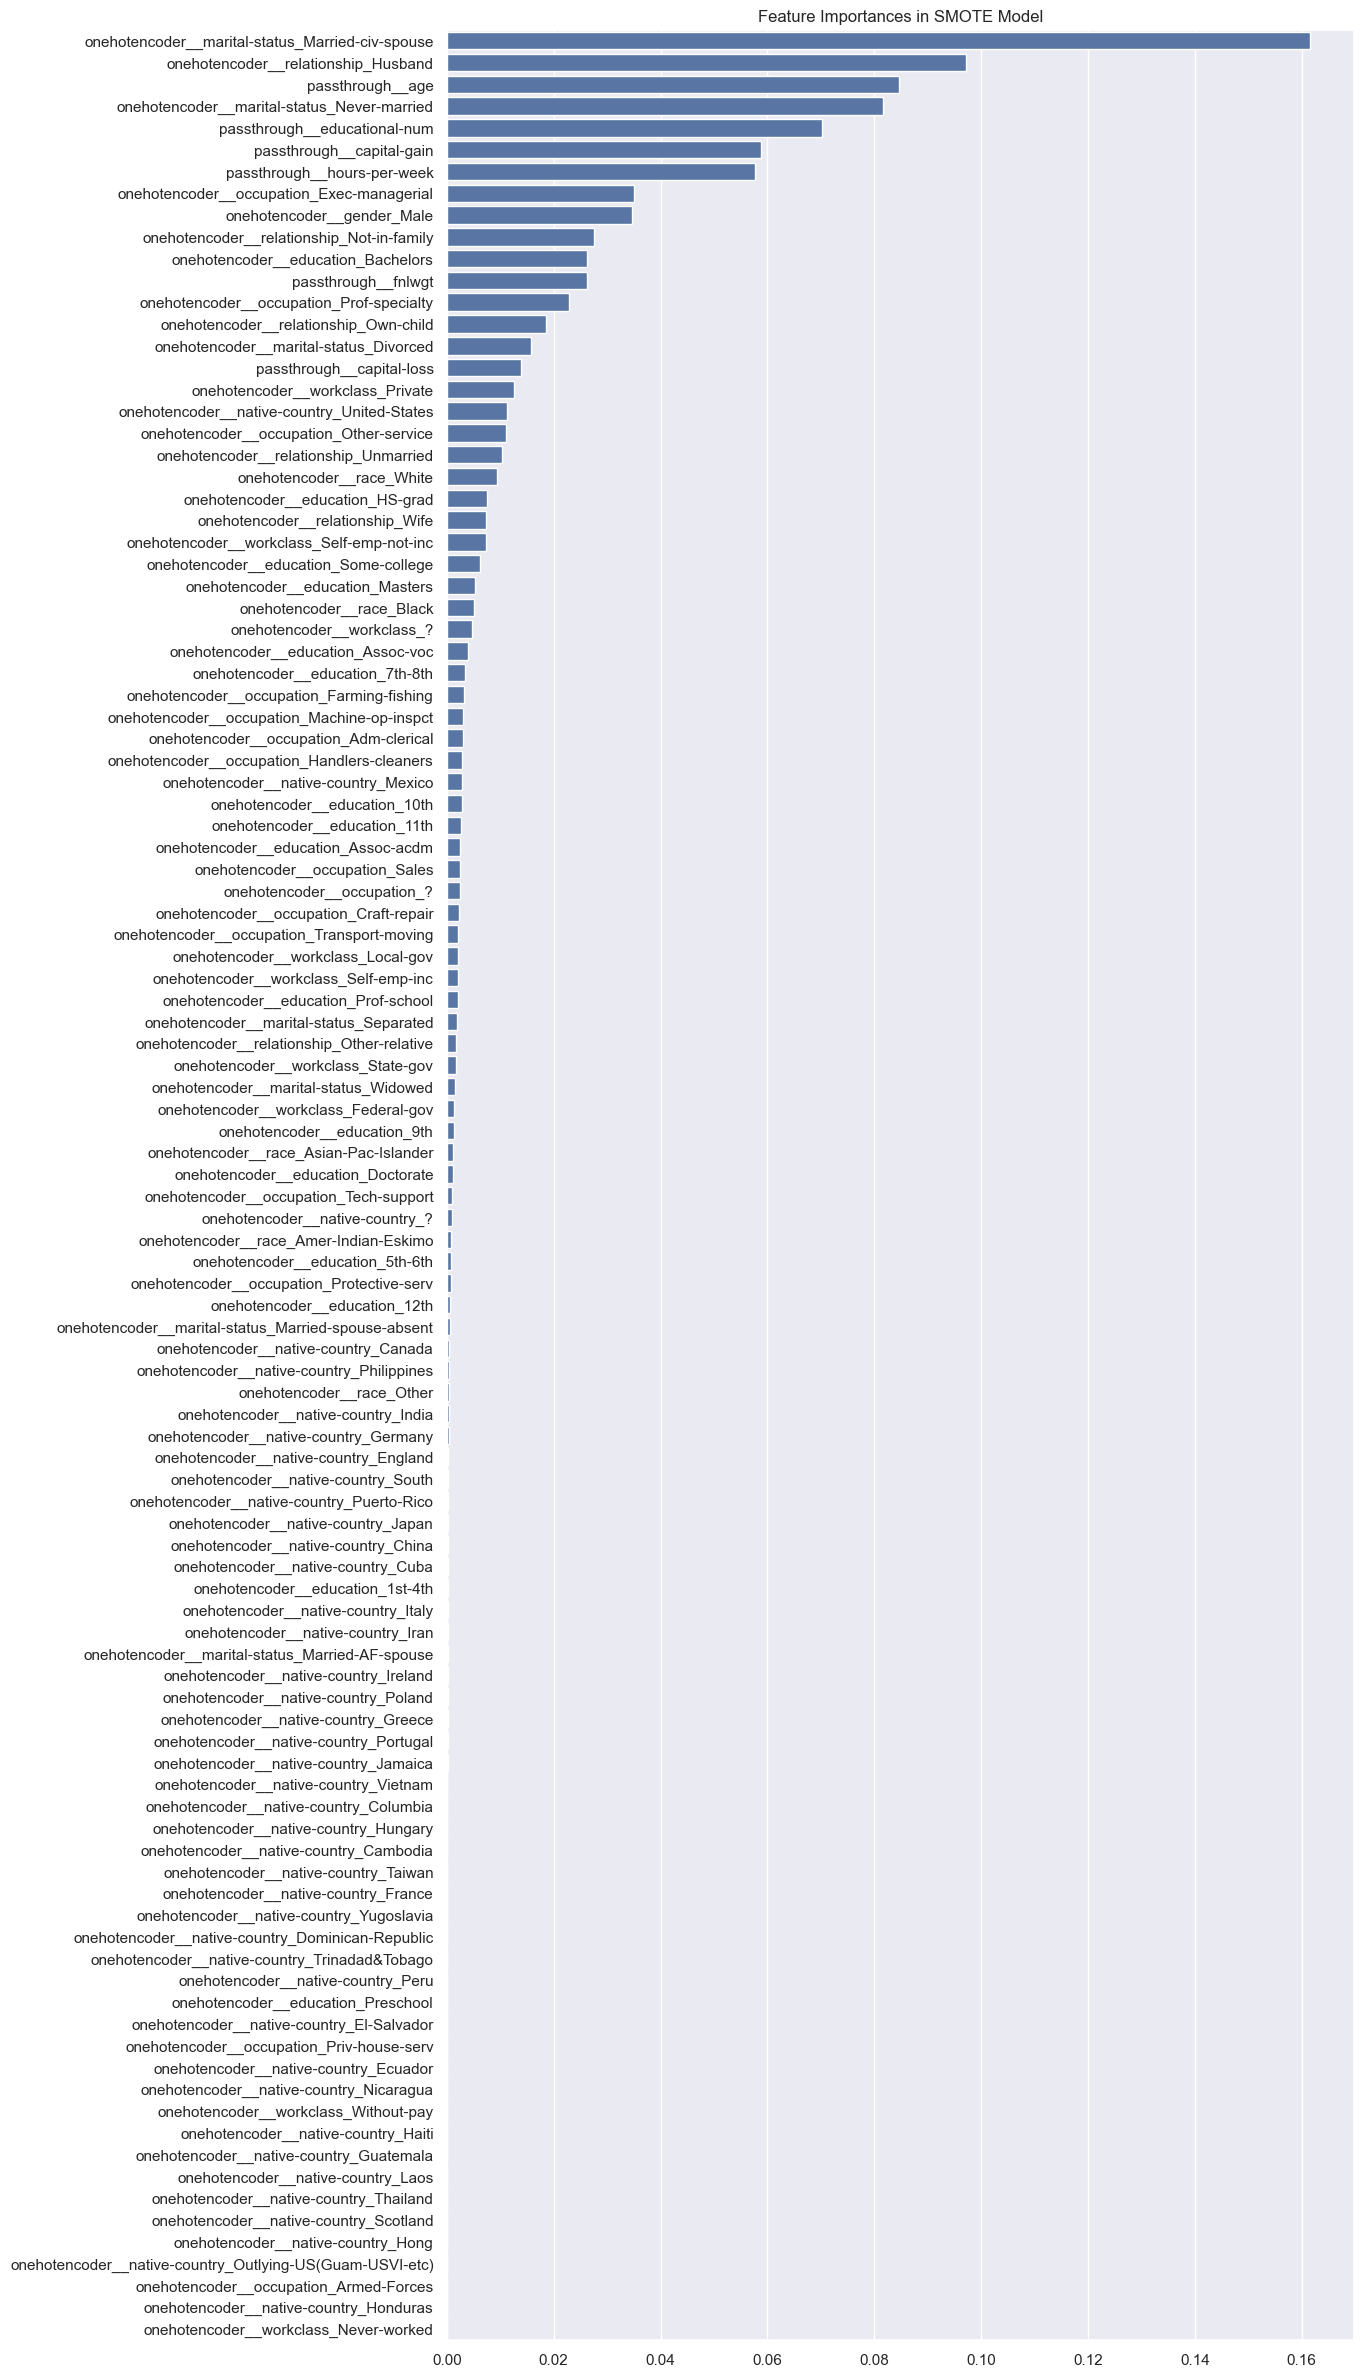

In [142]:
feature_importances_SMOTE = clf_SMOTE.feature_importances_
sorted_indices_SMOTE = feature_importances_SMOTE.argsort()[::-1]
sorted_feature_names_SMOTE = ctSMOTE.get_feature_names_out()[sorted_indices_SMOTE]
sorted_importances_SMOTE = feature_importances_SMOTE[sorted_indices_SMOTE]

sns.set(rc={'figure.figsize':(11.7,30)})
sns.barplot(x=sorted_importances_SMOTE, y=sorted_feature_names_SMOTE)
plt.title('Feature Importances in SMOTE Model')
plt.show()

Each method of addressing bias shifts the model's focus across various features. SMOTE reintroduce or shift emphasis on features like: `marital status` and `relationship`.

## Equalized odd post processing

An alternative to the methods seen so far (which may produce unsatisfactory results), is applying post-processing to the predictions of the classifier, so that they optimize equalized odds (whether the TPR and FPR are on par across groups).

`aif360`, a popular open-source library dedicated to detecting and mitigating bias in machine learning models, includes [`EqOddsPostprocessing`](https://aif360.readthedocs.io/en/stable/modules/generated/aif360.algorithms.postprocessing.EqOddsPostprocessing.html), a function to performe equalized odds post-processing. The function is slightly more intricate to use than others you have used so far (typically from `sklearn`), so we will see together how to apply it on the test (you may try and replicate this on the training set for your own practice).

In [180]:
# Run this cell to reset training and test sets (and clear accidental prior changes)

X_train, y_train = (
    train_df.drop(columns=["income"]),
    train_df["income"],
)
X_test, y_test = (
    test_df.drop(columns=["income"]),
    test_df["income"],
)

In [181]:
# Run this cell to do the necessary dataset preprocessing (encoding of categorical features).
# Note that, since we are using a tree based classifier, we don't need to scale the 
# numerical features.

categorical_feats = ["workclass",
                     "education",
                     "marital-status",
                     "occupation",
                     "relationship",
                     "race",
                     "gender",
                     "native-country",
                     ]  # Apply one-hot encoding
passthrough_feats = ["age",
                "fnlwgt",
                "educational-num",
                "capital-gain",
                "capital-loss",
                "hours-per-week"
                ]  # Numerical - no need to scale
target = "income"

ct = make_column_transformer(
    (
        make_pipeline(OneHotEncoder(handle_unknown="ignore",drop="if_binary")),
        categorical_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats)  # no transformations on numerical features
)

X_train_transformed = ct.fit_transform(X_train).toarray()
X_test_transformed = ct.transform(X_test).toarray()

In [182]:
# Convert numpy arrays to pandas dataframes

column_names = list(
    ct.named_transformers_["pipeline"].get_feature_names_out(
        categorical_feats
    )
) + passthrough_feats

X_train_df = pd.DataFrame(X_train_transformed, columns=column_names)
X_test_df = pd.DataFrame(X_test_transformed, columns=column_names)

In [183]:
# Train RandomForestClassifier
clf = RandomForestClassifier(random_state=0, max_depth = 19, n_estimators = 100).fit(X_train_df, y_train)

# Get predictions for test set 
y_pred = clf.predict(X_test_df)

# So far, all this is the same as the biased classifier we started with 

In [184]:
# Convert test data into a BinaryLabelDataset, necessary to work in aif360

from aif360.datasets import BinaryLabelDataset

X_test_df = X_test_df.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

y_binary = y_test.map({'>50K': 1, '<=50K': 0})  # Map categorical values to binary

test_bld = BinaryLabelDataset(df=pd.concat([X_test_df, y_binary], axis=1),
                              label_names=['income'],
                              protected_attribute_names=['gender_Male'])

In [185]:
# Create another dataset with predicted labels for comparison
test_pred_bld = test_bld.copy()

# Convert to binary label (e.g., class 2 is positive, others are negative)
y_pred_binary = np.where(y_pred == '>50K', 1, 0)

test_pred_bld.labels = y_pred_binary.reshape(-1, 1)

In [186]:
from aif360.algorithms.postprocessing import EqOddsPostprocessing

# Initialize EqOddsPostprocessing
eq_odds = EqOddsPostprocessing(unprivileged_groups=[{'gender_Male': 0}],
                               privileged_groups=[{'gender_Male': 1}])


In [187]:
# Fit the EqOddsPostprocessing model
eq_odds = eq_odds.fit(test_bld, test_pred_bld)

# Get new fair predictions
fair_pred_bld = eq_odds.predict(test_pred_bld)

# Convert predictions back to array
fair_predictions = fair_pred_bld.labels

In [188]:
fair_predictions_cat = np.where(fair_predictions == 1, '>50K', '<=50K')
fair_predictions_cat 

array([['<=50K'],
       ['<=50K'],
       ['<=50K'],
       ...,
       ['<=50K'],
       ['<=50K'],
       ['<=50K']], dtype='<U5')

`fair_predictions_cat` now includes the post-processed predictions, after equalized odds postprocessing. 

#### Question 7

Compute accuracy and fairness of this new predictions, and compare the results to the previous ones. Do we see any improvement? Is this technique more or less effective than the others tried before?

In [153]:
accuracy_test_eq_odds = accuracy_score(y_test, fair_predictions_cat)

next_index = accuracy_comparison.index.max() + 1
accuracy_comparison.loc[next_index] = ["EqOdds Post-Processed", None, accuracy_test_eq_odds]
accuracy_comparison.index = accuracy_comparison.index + 1
accuracy_comparison = accuracy_comparison.sort_index()

accuracy_comparison

,Model,Training Set Accuracy,Testing Set Accuracy
3,Original,0.907046,0.861462
4,Cleaned,0.919009,0.861530
5,Balanced,0.962170,0.802361
6,SMOTE,0.920682,0.841944
7,EqOdds Post-Processed,NaN,0.836825


In [189]:
gender_test = gender_test.reset_index(drop=True)
cm_b_test, cm_w_test = get_group_confusion_matrix(y_test, fair_predictions_cat, gender_test, "Female", "Male")
fairness_metrics["EqOdds Post-Processed_Test"] = compute_fairness_metrics(cm_b_test, cm_w_test)

# convert to DataFrame 
fairness_metrics_df = pd.DataFrame.from_dict(fairness_metrics, orient='index')

fairness_metrics_df

,PPRD,PPGRD,FDRD,FPRD,FORD,FNRD,Average Distance from Reference
Orignal_Train,0.172842,0.349042,0.370874,0.101238,0.265089,0.883967,0.642825
Orignal_Test,0.140122,0.281567,0.817173,0.179615,0.357543,1.237044,0.576837
Cleaned_Train,0.175075,0.353552,0.279112,0.077174,0.255225,0.853163,0.667783
Cleaned_Test,0.150408,0.302237,0.985436,0.232500,0.351786,1.214334,0.531995
Balanced_Train,0.959726,0.959726,0.337106,0.323529,0.519560,0.542857,0.392916
Balanced_Test,0.237109,0.476457,1.343874,0.499837,0.227620,0.904338,0.499752
SMOTE_Train,0.072110,0.239060,0.770999,0.087805,0.364001,3.173955,0.939997
SMOTE_Test,0.103781,0.208543,0.655867,0.106772,0.499459,2.105907,0.755248
EqOdds Post-Processed_Test,0.280530,0.563710,2.283262,1.004748,0.315619,0.997445,0.521784


Compared to the previous models, the EqOdds Post-Processed model, achieved a testing accuracy similar to the SMOTE model but without direct training modifications. <br>

The fairness metrics from the EqOdds Post-Processed model is improved, compared to the original model, and the ADR is dropped. Notably, FPRD and FNRD are very close to 1 which means the model did a great job in terms of the disparity of false positives rate and false negatives rate across male and female group.

The EqOdds Post-Processed model seems to have effectively mitigated some of the fairness concerns observed in the original and other modified models, especially in terms of reducing disparity in false discovery rates and balancing the false positive rates. It appears more effective in achieving fairness than earlier attempts with other debiasing techniques. This suggests that post-processing predictions to enforce equalized odds can be a powerful approach to reducing bias in machine learning models, especially when direct manipulation of the training data either does not yield the desired fairness or adversely impacts model accuracy.

## Final remarks

#### Question 8

Based on the results seen so far, provide an overall evaluation of our debiasing efforts. In particular, try answering the following questions:
1. What do you think was the most successful technique? Which one was the least successful? 
2. If you found that bias still persists after attempting a debiasing strategy, what do you think is the reason? What could be done to fix this problem?

(max 400 words)

1.
- Based on our analysis of different debiasing techniques, the EqOdds Post-Processing seems the most successful technique. It achieves a strong balance between model performance and fairness, maintaining a reasonable test accuracy of 83.68% while showing significant improvements in fairness metrics. Especially in false positive and false discovery rates closer to parity (FPRD = 1.004748, FNRD = 0.997445). It also demonstrates substantial improvement in the prediction rate disparity (PPGRD = 0.563710) compared to the original model.
- The technique that dropped protected characteristics (gender, race, and native country) could be the least successful technique. This approach did not result in substantial improvements in fairness metrics and also did not manage to maintain or improve accuracy compared to the original model. Additionally, removing these features might inadvertently ignore these attributes' influence on bias, potentially allowing other variables correlated with the protected attributes to introduce hidden biases.

2. 
- Bias persisted across various models, even after attempting debiasing strategies. For example: undersampling have potential risk of overfitting on the smaller size of dataset; oversampling (SMOTE) consider balancing the target variables only and synthetic data points it creates are based on the existing data. If the minority class is not well-represented or is very diverse, SMOTE might create synthetic instances that don't accurately represent possible real-world observations. The bias exists primarily because each technique primarily addresses specific aspects of fairness, often without capturing the entire spectrum of biases that can exist in data and model predictions. 
- To further address these persistent biases, a combination of strategies along with more robust data collection could be considered, for example we can use SMOTE first, then do undersampling. Also can have interventions on data collected: expanding the dataset to include more diverse examples can help the models learn more generalized representations, reducing the risk of bias towards any particular group, and addressing historical biases in data collection.



# Final thoughts

1) If you have completed this assignment in a group, please write a detailed description of how you divided the work and how you helped each other completing it:

We didn't really divide the work, we did all the questions together, gathering thoughts and organizing sentences. 

2) Have you used ChatGPT or a similar Large Language Model (LLM) to complete this homework? Please describe how you used the tool. We will never deduct points for using LLMs for completing homework assignments, but this helps us understand how you are using the tool and advise you in case we believe you are using it incorrectly.

Yes , we used ChatGPT to explain the concepts we feel confused, so that we can understand the question better.

3) Have you struggled with some parts (or all) of this homework? Do you have pending questions you would like to ask? Write them down here!

Exam if the fairness metrics is corrected generated.